# Business Ambience Classifier

My goal was to create a small web service that accepts a series of adjectives like 'hipster' or 'trendy' and serve a handful of businesses that fit this description. I realized that Yelp already had this attribute (called ambience), but many businesses didn't have a single ambience set. 

This notebook contains my attempt at building a classifier for ambience based on review text.

## Setup

In [168]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import json
import random

from IPython.display import display, Image
from scipy.io import mmread, mmwrite
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from wordcloud import WordCloud

plt.style.use('ggplot')

In [3]:
def create_dataframe(data_type):
    with open('dataset/yelp_academic_dataset_{}.json'.format(data_type)) as f:
        data = [json.loads(entry) for entry in f]
    data = pd.io.json.json_normalize(data)
    return pd.DataFrame(data)

business_df = create_dataframe('business')
business_df.to_csv('business_df.csv', encoding='utf-8')

review_df = create_dataframe('review')
review_df.to_csv('review_df.csv', encoding='utf-8')

In [5]:
business_df = pd.read_csv('business_df.csv')
review_df = pd.read_csv('review_df.csv')

## Ambience Column (Labels)

In [90]:
ambience_map = {
    0: 'intimate',
    1: 'hipster',
    2: 'divey',
    3: 'touristy',
    4: 'upscale',
    5: 'trendy',
    6: 'casual',
    -1: 'other',
}

def ambience(romantic, intimate, classy, hipster, divey, touristy, upscale, trendy, casual):
    if romantic == True or intimate == True:
        return 0
    if hipster == True:
        return 1
    if divey == True:
        return 2
    if touristy == True:
        return 3
    if upscale == True or classy == True:
        return 4
    if trendy == True:
        return 5
    if casual == True:
        return 6
    return -1

In [7]:
business_df['ambience_int'] = np.vectorize(ambience)(
    business_df['attributes.Ambience.romantic'],
    business_df['attributes.Ambience.intimate'],
    business_df['attributes.Ambience.classy'],
    business_df['attributes.Ambience.hipster'],
    business_df['attributes.Ambience.divey'],
    business_df['attributes.Ambience.touristy'],
    business_df['attributes.Ambience.upscale'],
    business_df['attributes.Ambience.trendy'],
    business_df['attributes.Ambience.casual'],
)

## Tf-idf Matrix (Features)

#### Joining review-text together based on business

In [14]:
biz_combined_reviews = review_df.groupby('business_id')['text'].apply(lambda x: ' '.join(x))

def get_combined_reviews(business_id):
    return biz_combined_reviews.get(business_id, default='')

business_df['combined_reviews'] = business_df['business_id'].apply(get_combined_reviews)

#### Businesses with ambience attribute

In [17]:
businesses_with_ambience = business_df[business_df['ambience_int'] != -1]
print 'Businesses with ambience attribute: {}'.format(len(businesses_with_ambience))

Businesses with ambience attribute: 13070


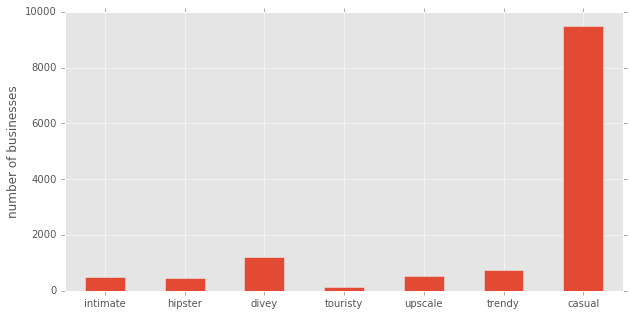

In [98]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
businesses_with_ambience.groupby('ambience_int').size().plot(kind='bar', rot=0)
ax.set_xticklabels([ambience_map[idx] for idx in list(ax.get_xticks())])
ax.set_xlabel('')
ax.set_ylabel('number of businesses')

#### Labels

In [18]:
y = businesses_with_ambience['ambience_int'].values

#### Tf-idf features

In [80]:
vectorizer = TfidfVectorizer(max_df=0.7, min_df=0.1, stop_words='english')
X_tfidf = vectorizer.fit_transform(businesses_with_ambience['combined_reviews'].values)
mmwrite('tfidf.mtx', X_tfidf)

In [81]:
X_tfidf = mmread('tfidf.mtx')

In [99]:
len(vectorizer.get_feature_names())

2886

## Train OneVsRest Classifier

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2)

In [83]:
classifier = OneVsRestClassifier(LinearSVC())
classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1)

#### Score

In [84]:
classifier.score(X_test, y_test)

0.78615149196633516

#### Confusion Matrix####
By definition a confusion matrix C is such that C[i][j] is equal to the number of observations known to be in group i but predicted to be in group j.
***

In [159]:
C = confusion_matrix(y_test, classifier.predict(X_test))
C

array([[  41,    1,    2,    0,   19,    4,   35],
       [   3,    8,    3,    0,    2,   12,   50],
       [   0,    2,   72,    0,    1,    1,  161],
       [   0,    0,    1,    1,    3,    2,   23],
       [  19,    0,    2,    0,   40,   18,   26],
       [   3,    2,    2,    0,    9,   56,   75],
       [   9,    8,   30,    1,   12,   18, 1837]])

***
The largest number (that is not along the diagonal, because those are correct predictions) is at C[2][6], which means that our classifier struggles the most with categorizing divey businesses as casual. Actually, incorrectly categorizing businesses as casual is the main issue with the classifier in general.

## Exploring Individual Classifiers (Word Maps)

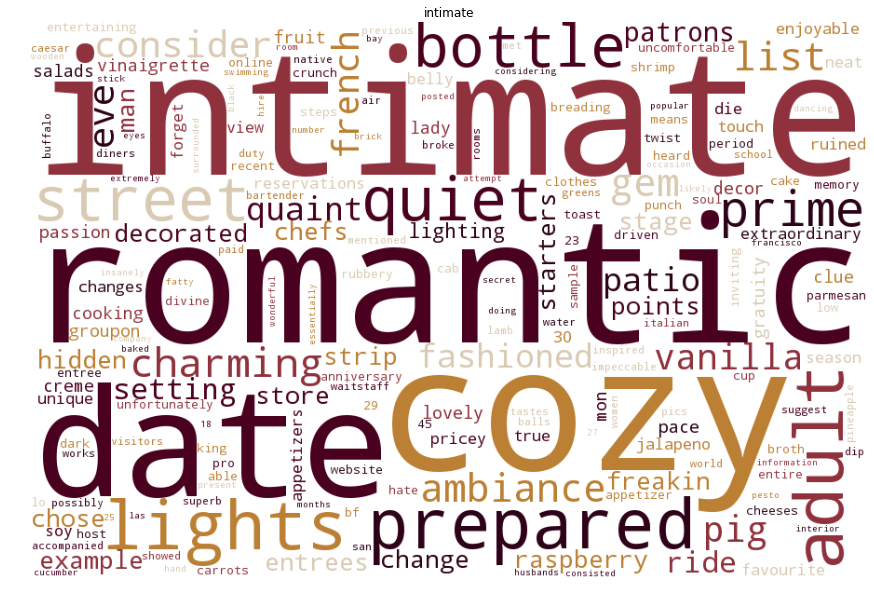

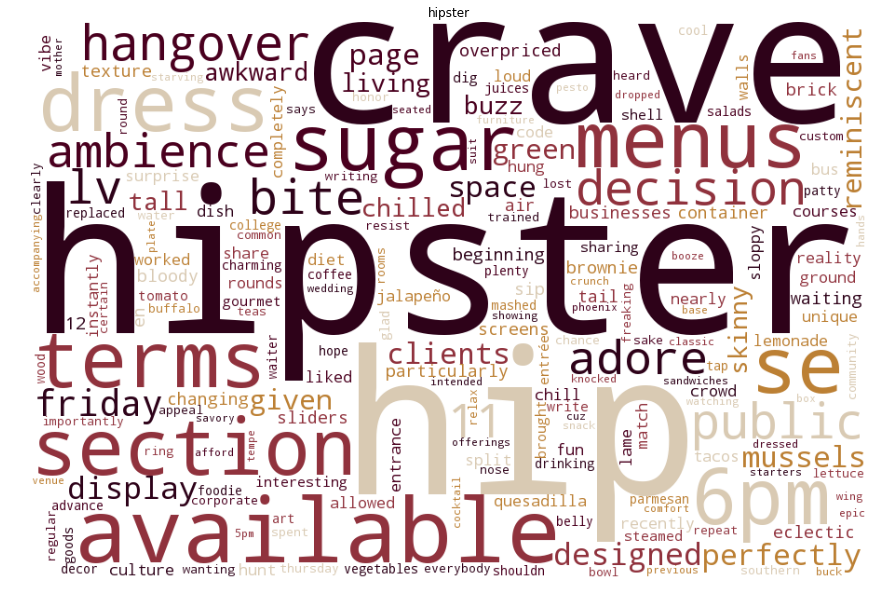

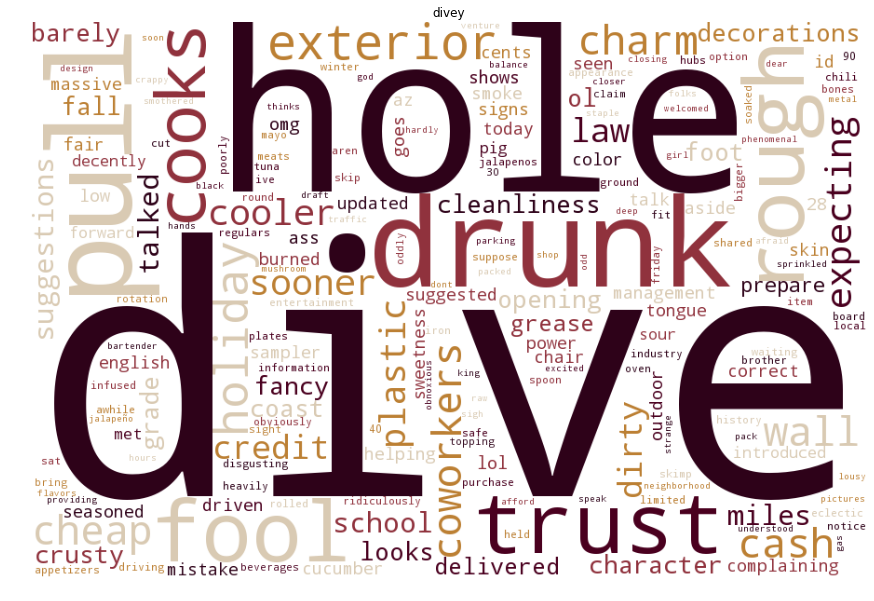

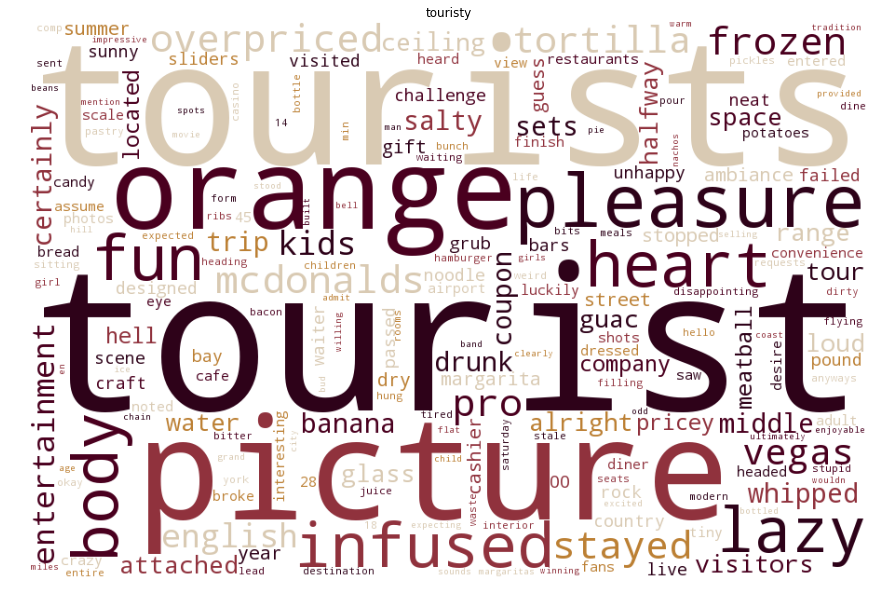

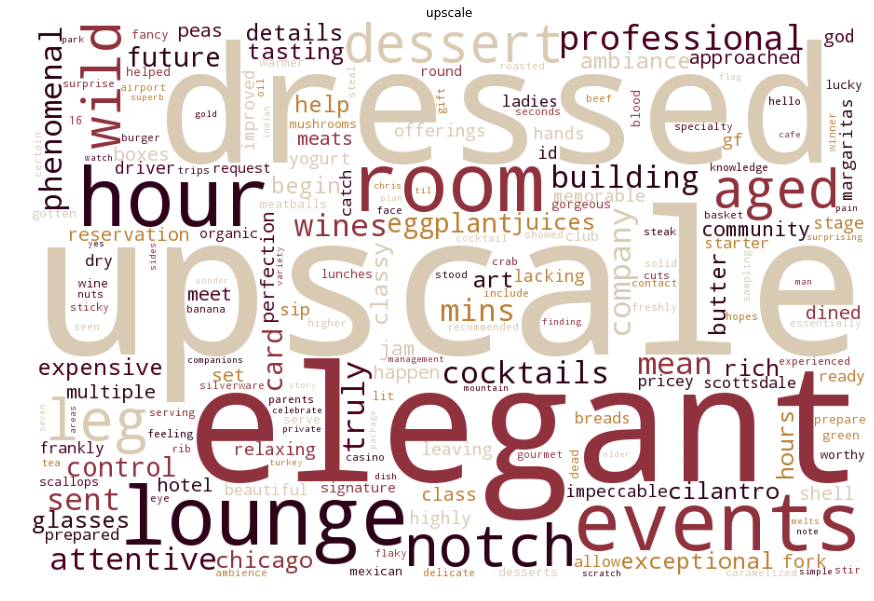

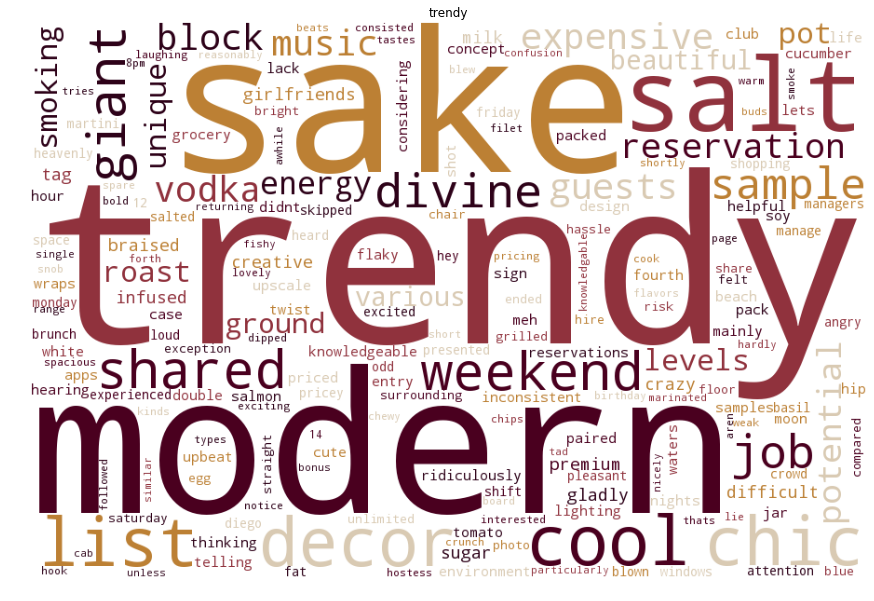

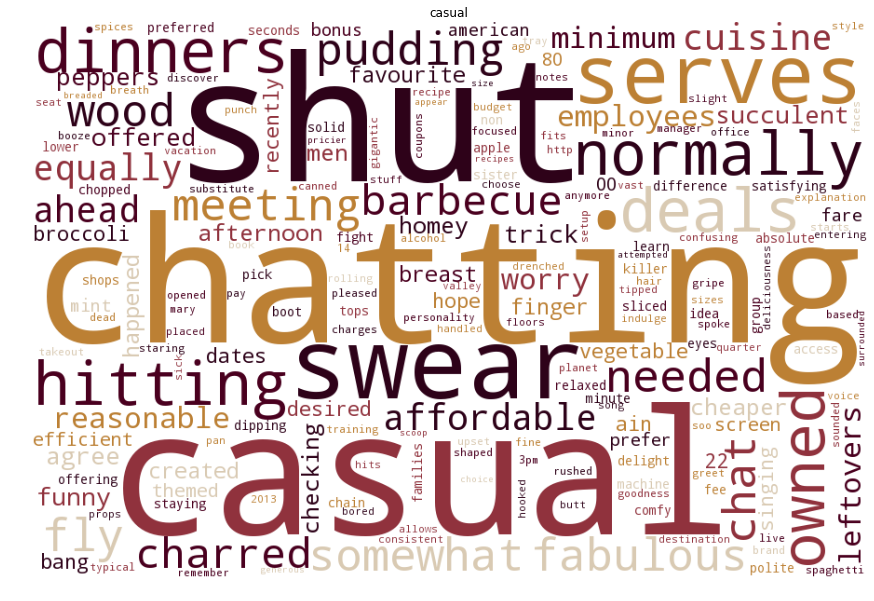

In [87]:
def custom_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice([
        '#2E0219',
        '#4A001F',
        '#90323D',
        '#D9CAB3',
        '#BC8034',
    ])

feature_names = vectorizer.get_feature_names()
for idx, individual_classifier in enumerate(classifier.estimators_):
    frequencies = zip(feature_names, individual_classifier.coef_[0])
    wordcloud = WordCloud(
        background_color='white',
        color_func=custom_color,
        height=600,
        width=900,
    )
    wordcloud_img = wordcloud.generate_from_frequencies(frequencies)
    fig = plt.figure()
    fig.set_size_inches(15, 10)
    plt.title('{}'.format(ambience_map[idx]))
    plt.imshow(wordcloud_img)
    plt.axis("off")

Naturally, the strongest signals are the ambiences themselves or synonyms. Some interesting signals (that are obvious to humans):

intimate: date, bottle, french

hipster: crave, hangover, sugar, se

divey: hole, drunk, trust

touristy: picture, pleasure

upscale: elegant, lounge, dressed

trendy: sake, cool, chic, reservation

## Build an Itinerary

Add the predicted ambience column

In [113]:
def get_ambience_prediction(ambience_int, combined_reviews):
    if ambience_int != -1:
        return ambience_map[ambience_int]
    
    tfidf = vectorizer.transform([combined_reviews])
    prediction_int = int(classifier.predict(tfidf))
    return ambience_map[prediction_int]

business_df['ambience'] = np.vectorize(get_ambience_prediction)(
    business_df['ambience_int'],
    business_df['combined_reviews'],
)

Simple pandas filtering, this is _very_ rough.

In [135]:
def print_itinerary(city, categories, ambience, min_stars):
    for category in categories:
        search_space = business_df[
            (business_df['city'] == city) &
            (business_df['ambience'] == ambience) &
            (business_df['stars'] >= min_stars) &
            (business_df['categories'].str.contains(category))
        ]
        display(search_space.sample(n=1)[['name', 'categories', 'stars']])

In [180]:
print_itinerary('Las Vegas', ['Breakfast', 'Shopping', 'Restaurant', 'Entertainment', 'Gastropub'], 'intimate', 3)

,name,categories,stars
18835,Mon Ami Gabi,"[Breakfast & Brunch, Steakhouses, French, Rest...",4.0


,name,categories,stars
63794,Artifact,"[Arts & Crafts, Shopping]",4.5


,name,categories,stars
27310,Sea Stone,"[Sushi Bars, Asian Fusion, Restaurants]",3.0


,name,categories,stars
70498,Sydney After Dark,"[Adult Entertainment, Nightlife]",3.0


,name,categories,stars
68118,The Blind Pig,"[Gastropubs, Restaurants]",4.0


I'm not too familiar with any of the cities in the dataset, but this looks like it could be promising...

## Reviews From Other Sources

#### Other Yelp businesses

Let's try classifying a business that's not in the dataset. This is a [cafe](https://www.yelp.com/biz/haus-coffee-san-francisco) that I frequent in the Mission that's _definitely_ hipster.

<img src="https://s3-media1.fl.yelpcdn.com/bphoto/Aguvgm01n4XKCEzjhB90PQ/o.jpg" width=200 align="left"/>

In [175]:
with open('haus_reviews') as f:
    haus_reviews = f.read()
get_ambience_prediction(-1, haus_reviews)

'hipster'

I downloaded the first 40 reviews for this business off of Yelp and saved it to a file called 'haus_reviews'. Look like the classifier correctly labeled it as hipster (though this is a pretty obvious one)!
***
Let's try an example for divey. This is a divey (but great!) [bar](https://www.yelp.com/biz/tempest-san-francisco) in SoMa called Tempest.

<img src="https://s3-media3.fl.yelpcdn.com/bphoto/1pGf9ZjfVkykSo7yNzGQ6Q/o.jpg" width=300 align="left"/>

In [177]:
with open('tempest_reviews') as f:
    tempest_reviews = f.read()
get_ambience_prediction(-1, tempest_reviews)

'divey'

Sweet! The business itself is categorized as a dive bar, but the classifier doesn't know that. It can detect the ambience just from the first 40 reviews (though this is another obvious example).

#### Google Reviews
Let's try some examples from other sources. Google has some (low quality) reviews of businesses we can test the classifier on. Let's run the classifier on Google's first 40-ish reviews for Tempest.

In [182]:
with open('tempest_crappy_reviews') as f:
    tempest_crappy_reviews = f.read()
get_ambience_prediction(-1, tempest_crappy_reviews)

'divey'

Nice! The classification works! Note: Google reviews really suck and are usually 0.5-1 sentence long.